### IMPORT MODULES

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# update plot formatting
mpl.rcParams.update({'font.size': 14})
mpl.rcParams.update({'mathtext.default': 'rm'})
mpl.rcParams.update({'font.family': 'sans-serif'})
mpl.rcParams.update({'font.sans-serif': 'Calibri'})

### USER INPUT

In [3]:
# output folder to read from
folder = 'outputs 2024-08-09 baseline'

In [4]:
# scenario to plot
scenario = 'closed loop'

In [5]:
# CO2 recycling cost group breakdown

# NOTE: This applies to the specific case of 1000 kg H2/day station capacity 
# (7.968 kt CO2/year) and 100 mile transport distance,
# with values calculated from the MuMo-CoCo model (in "inputs/CO2 transport model" folder).
# A future version of "s2a_systems_functions.py" can incorporate CO2 recycling cost breakdown.

# cost fractions
cost_frac_capex = 0.4939 # capital and financing costs (capex and finex)
cost_frac_energy = 0.0499 # energy costs (electricity and fuel)
cost_frac_om = 0.4562 # operating costs (OPEX) excluding energy

# sanity check: cost fractions add up to 1
cost_frac_om + cost_frac_energy + cost_frac_capex

1.0

In [6]:
# function mapping
# use for remapping and regrouping
function_remap = {
    'vaporization' : 'other',
    'cooling' : 'other',
    'purchase' : 'H2 production',
    'trucking' : 'H2/LOHC trucking',
    }

In [7]:
# pathway name mapping
# use for string replacements and subplot order
pathway_name_map = {
    'compressed hydrogen' : 'Compressed hydrogen', 
    'liquid hydrogen' : 'Liquid hydrogen', 
    'LOHC - formic acid' : 'Formic acid LOHC',
}

# variable group name mapping
# use for string replacements and legend order in plot
var_group_name_map = {
    'capital cost' : 'Capital cost',
    'energy cost' : 'Energy cost',
    'O&M cost' : 'Non-energy O&M cost',
}

# function name mapping
# use for string replacements and axis label order in plot

# delivery-only scenario
function_name_map_1w = {
    'liquefaction' : 'Liquefaction',
    'compression' : 'Compression',
    'pumping' : 'Pumping',
    'storage' : 'Storage',
    'H2/LOHC trucking' : '${H_2}$/LOHC trucking',
    'reaction' : 'Reaction',
    'separation' : 'Separation',
    'other' : 'Other',
}

# closed-loop scenario
function_name_map_2w = {
    'H2 production' : '${H_2}$ production',
    'CO2 recycling' : '${CO_2}$ recycling',
}
function_name_map_2w.update(function_name_map_1w)

In [8]:
# bar colors
# seaborn colorblind palette
# https://seaborn.pydata.org/tutorial/color_palettes.html
colors = sns.color_palette('colorblind')

# use grey for "other"
bar_colors = colors [0:2] + [colors[-3]]

In [9]:
# number of pathways
num_paths = len(pathway_name_map)

In [10]:
# function categories to use for selected scenario

function_name_map = function_name_map_2w

if scenario == 'delivery only':
    function_name_map = function_name_map_1w

print(function_name_map)

{'H2 production': '${H_2}$ production', 'CO2 recycling': '${CO_2}$ recycling', 'liquefaction': 'Liquefaction', 'compression': 'Compression', 'pumping': 'Pumping', 'storage': 'Storage', 'H2/LOHC trucking': '${H_2}$/LOHC trucking', 'reaction': 'Reaction', 'separation': 'Separation', 'other': 'Other'}


### READ INPUT PARAMETERS

In [11]:
# read input parameter map
df_input_params = pd.read_csv(
    os.path.join('..\outputs', folder, 'input params.csv')
    )

# extract output dollar year
output_dollar_year = df_input_params['output dollar year'].values[0]

# extract run number
run_num = df_input_params.loc[
    df_input_params['scenario'] == scenario, 'run #'].values[0]

### DATA PROCESSING

In [12]:
# read csv
f = 'output_' + str(run_num).zfill(4) + '.csv'
df = pd.read_csv(os.path.join('..\outputs', folder, f))

In [13]:
# filter results by units
df_usd_per_kg = df.loc[df['unit'] == '$/kg H2'].reset_index(drop=True)

# convert "value" columns to float
df_usd_per_kg['value'] = df_usd_per_kg['value'].astype(float)

# remap functions
df_usd_per_kg['function'].replace(function_remap, inplace=True)

df_usd_per_kg

,pathway,process,location,function,equipment,variable group,variable name,unit,value
0,compressed hydrogen,production,terminal,H2 production,hydrogen purchase,O&M cost,purchase cost,$/kg H2,0.310000
1,compressed hydrogen,preconditioning,terminal,compression,loading compressor,capital cost,levelized capital cost,$/kg H2,0.536905
2,compressed hydrogen,preconditioning,terminal,compression,storage compressor,capital cost,levelized capital cost,$/kg H2,0.475392
3,compressed hydrogen,preconditioning,terminal,storage,compressed gas storage,capital cost,levelized capital cost,$/kg H2,0.486149
4,compressed hydrogen,preconditioning,terminal,compression,loading compressor,O&M cost,"operation, maintenance, repair costs",$/kg H2,0.099001
...,...,...,...,...,...,...,...,...,...
147,LOHC - formic acid,reconditioning,refueling station,pumping,reactor pump,energy cost,electricity cost,$/kg H2,0.000000
148,LOHC - formic acid,reconditioning,refueling station,other,PSA refrigerator,energy cost,electricity cost,$/kg H2,0.001384
149,LOHC - formic acid,reconditioning,refueling station,separation,PSA,energy cost,electricity cost,$/kg H2,1.019590
150,LOHC - formic acid,reconditioning,refueling station,compression,compressor,energy cost,electricity cost,$/kg H2,0.425336


In [14]:
# regroup results by pathway, (remapped) function, and variable group
df_func_raw = df_usd_per_kg.groupby(
    by = ['pathway', 'function', 'variable group']
    )['value'].sum().reset_index()

df_func_raw

,pathway,function,variable group,value
0,LOHC - formic acid,CO2 recycling,capital cost,10.141291
1,LOHC - formic acid,H2 production,O&M cost,0.310031
2,LOHC - formic acid,H2/LOHC trucking,O&M cost,0.450772
3,LOHC - formic acid,H2/LOHC trucking,capital cost,0.416534
4,LOHC - formic acid,H2/LOHC trucking,energy cost,0.127191
5,LOHC - formic acid,compression,O&M cost,0.551625
6,LOHC - formic acid,compression,capital cost,1.627792
7,LOHC - formic acid,compression,energy cost,0.425336
8,LOHC - formic acid,other,O&M cost,0.034970
9,LOHC - formic acid,other,capital cost,0.087864


In [15]:
# break out CO2 recycling cost

# extract CO2 recycling cost row as new dataframe
df_co2_all = df_func_raw.loc[
    df_func_raw['function'] == 'CO2 recycling'].copy()

# create dataframe for capital cost
df_co2_capex = df_co2_all.copy()
df_co2_capex['value'] = df_co2_all['value'] * cost_frac_capex

# create dataframe for energy cost
df_co2_energy = df_co2_all.copy()
df_co2_energy['value'] = df_co2_all['value'] * cost_frac_energy
df_co2_energy['variable group'] = 'energy cost'

# create dataframe for O&M cost (excluding energy)
df_co2_om = df_co2_all.copy()
df_co2_om['value'] = df_co2_all['value'] * cost_frac_om
df_co2_om['variable group'] = 'O&M cost'

# concatenate dataframes
df_co2 = pd.concat(
    [df_co2_capex, df_co2_energy, df_co2_om], 
    ignore_index=True
)

df_co2

,pathway,function,variable group,value
0,LOHC - formic acid,CO2 recycling,capital cost,5.008783
1,LOHC - formic acid,CO2 recycling,energy cost,0.506050
2,LOHC - formic acid,CO2 recycling,O&M cost,4.626457


In [16]:
# add CO2 recycling cost breakdown to other cost results
df_other = df_func_raw.loc[
    df_func_raw['function'] != 'CO2 recycling'].copy()
df_func = pd.concat([df_other, df_co2], ignore_index=True)

# replace pathway, function, and variable group names for plot
df_func['pathway'].replace(pathway_name_map, inplace=True)
df_func['function'].replace(function_name_map, inplace=True)
df_func['variable group'].replace(var_group_name_map, inplace=True)

df_func

,pathway,function,variable group,value
0,Formic acid LOHC,${H_2}$ production,Non-energy O&M cost,0.310031
1,Formic acid LOHC,${H_2}$/LOHC trucking,Non-energy O&M cost,0.450772
2,Formic acid LOHC,${H_2}$/LOHC trucking,Capital cost,0.416534
3,Formic acid LOHC,${H_2}$/LOHC trucking,Energy cost,0.127191
4,Formic acid LOHC,Compression,Non-energy O&M cost,0.551625
5,Formic acid LOHC,Compression,Capital cost,1.627792
6,Formic acid LOHC,Compression,Energy cost,0.425336
7,Formic acid LOHC,Other,Non-energy O&M cost,0.034970
8,Formic acid LOHC,Other,Capital cost,0.087864
9,Formic acid LOHC,Other,Energy cost,0.061234


In [17]:
# calculate y-axis limit for cost breakdown

# regroup results by pathway and remapped function
df_func_tot = df_usd_per_kg.groupby(
    by = ['pathway', 'function']
    )['value'].sum()

# find highest cost of all functions
ymax = np.ceil(df_func_tot.max())

ymax

11.0

### PLOT: hydrogen cost breakdown

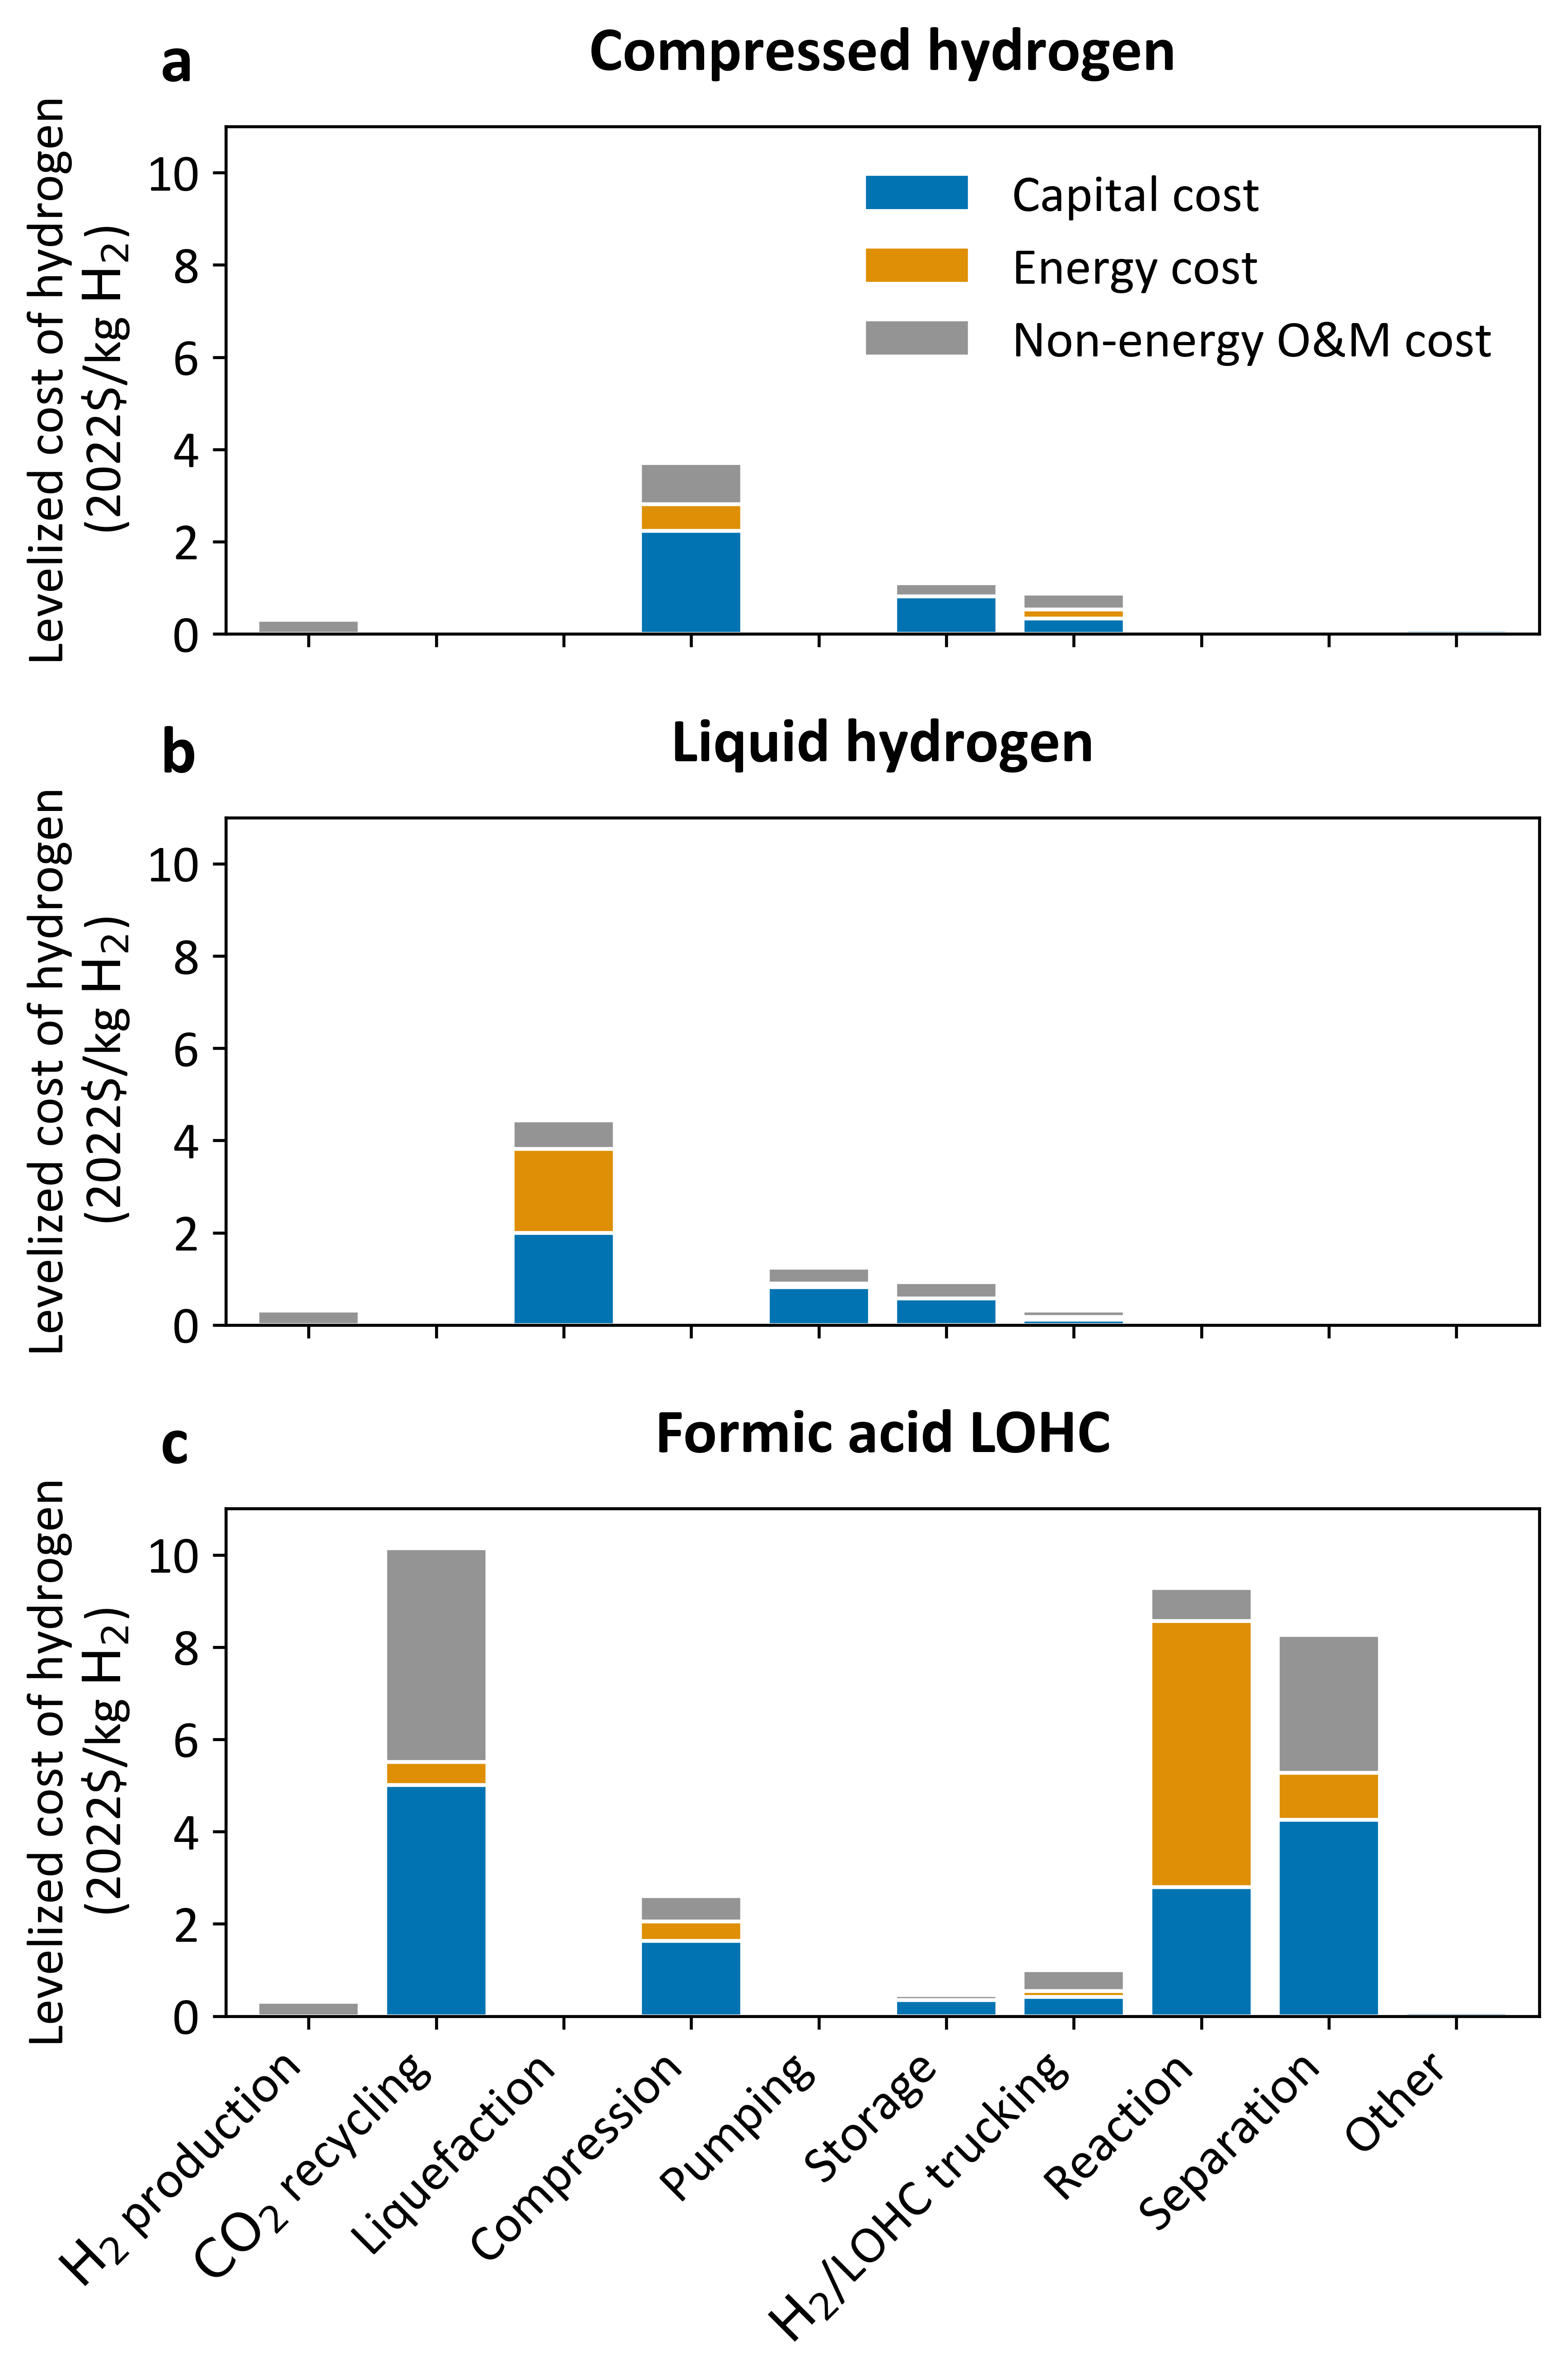

In [18]:
# create subplots
fig, axes = plt.subplots(
    layout='tight',
    nrows=num_paths,
    sharex=True,
    sharey=True,
    figsize=(6, 9),
    dpi=600
)

# subplot numbering
text = ['a', 'b' , 'c']

# fill subplots
for p in range(num_paths):

    # filter results for each pathway
    pathway = list(pathway_name_map.values())[p]
    df_func_p = df_func.loc[df_func['pathway'] == pathway].copy()
    df_func_p.drop(columns='pathway', inplace=True)
    
    # pivot dataframe
    df_func_p = df_func_p.pivot(
        columns='variable group',
        index='function',
        values='value',
    ).fillna(0)
    
    # reindex by function category and fill missing values
    df_func_p = df_func_p.reindex(function_name_map.values(), fill_value=0).reset_index()

    # plot results for each pathway
    df_func_p.plot.bar(
        ax=axes[p],
        x='function',
        y=var_group_name_map.values(),
        yticks=np.arange(0, ymax*1.001, 2),
        ylim=(0, ymax),
        stacked=True,
        width=0.8,
        color=bar_colors,
        edgecolor='white',
    )
    
    # update subplot titles and numbering
    axes[p].set_title(
        pathway,
        fontweight='bold',
        pad=15
    )

    axes[p].annotate(
        text[p], 
        xy=(-0.05, 1.09), 
        xycoords='axes fraction', 
        annotation_clip=False,
        fontsize=18,
        fontweight='bold'
    )

# update axis settings
for ax in axes:
    ax.set_ylabel(
        'Levelized cost of hydrogen\n' + \
        '({}\\$/kg'.format(output_dollar_year) + ' ${H_2}$)')

    # remove x-axis label
    ax.set_xlabel('')

axes[-1].set_xticks(
    axes[-1].get_xticks(), 
    axes[-1].get_xticklabels(), 
    rotation=45,
    ha='right',
)

# add legend for figure
for ax in axes:
    ax.get_legend().remove()

handles, labels = axes[-1].get_legend_handles_labels()

axes[0].legend(
    handles=handles, 
    labels=labels, 
    frameon=False, 
    bbox_to_anchor=(0.45, 1), 
    loc='upper left',
    )

# save plot
plt.savefig(
    'cost breakdown_capex vs opex_' + scenario + '.png',
    bbox_inches='tight'
    )
    
# show plot
plt.show()